# Variational Autoencoder on MNIST

## Importing required libraries

In [90]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import random 
from keras.datasets import mnist
import pandas as pd



## Preparing the dataset
The dataset is loaded and the grayscale values are normalized. The dataset is then reshaped to a shape approriate for being fed to the VAE.

In [4]:
def preprocess(x_train, x_test):
    x_train = x_train.astype('float32')/255
    x_test = x_test.astype('float32')/255
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
    return x_train, x_test

In [5]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x, test_x = preprocess(train_x, test_x)

## Defining the architecture
### Sampling
In this part a method is defined in which a reparameterisation trick is leveraged. Despite the random sampling that occurs from the latent space, the loss needs to backpropagate through it to make the training possible. Thus, the variable epsilon is defined which is randomly sampled from the normal distribution and using the formula below the sampling is done from the latent space: <br>
means + standard_deviations*epsilon

In [6]:
def sample(means_log_var):
    means, log_var = means_log_var
    epsilon = K.random_normal(shape=(K.shape(means)[0], latent_dim), mean=0, stddev=1)
    return means + K.exp(log_var/2) * epsilon

### Defining the encoder
The encoder part of the VAE is consisted of two 2-dimensional Convolutional layers followed by a flattening and a dense layer. It outputs the means and logarithms of the variances of the latent space distributions and the sample.

In [8]:
img_shape = (28, 28, 1)
latent_dim = 2
input_layer = keras.Input(shape=img_shape)
x = keras.layers.Conv2D(32, 3, padding='same', activation='relu',strides=(2, 2))(input_layer)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
shape = K.int_shape(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)


means = keras.layers.Dense(latent_dim)(x)
log_var = keras.layers.Dense(latent_dim)(x)

z = Lambda(sample, output_shape = (latent_dim, ))([means, log_var])

encoder = Model(input_layer, [means, log_var, z])
print(encoder.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_4[0][0]                   
____________________________________________________________________________________________

### Defining the decoder
The decoder has to be defined in a manner that results in a final output with the same shape as the input images. Here, the architecture consists of a dense layer (with the same number of parameters as before flattening in the encoder part), a reshaping layer (turining the flattened data to their shape before flattening) and three 2-dimenstional transpose convolutional layers.

In [9]:
decoder_input = keras.layers.Input(shape =(latent_dim,))
x = keras.layers.Dense(shape[1]*shape[2]*shape[3],activation='relu')(decoder_input)
x = keras.layers.Reshape(shape[1:])(x)
x = keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
outputs = keras.layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, outputs)
print(decoder.summary())
x_prime = decoder(z)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

### Defining the loss function
The loss function is consisted of two parts: 1) The reconstruction term and 2) The regularisation term.
While the reconstruction term (usually scaled crossentropy or MSE) ensures an accurate reconstruction of the images, the regularisation term ensures a regularised organisation of the latent space by making the distributions close to a standard normal distribution (ensuring the continuty and completeness of the latent space).

In [10]:
def my_loss(x, x_prime):
    x = K.flatten(x)
    x_prime = K.flatten(x_prime)
    reconstruct_loss = 28*28*keras.metrics.binary_crossentropy(x, x_prime)
    kl_loss = -0.5* K.sum(1 + log_var - K.square(means) - K.exp(log_var), axis = -1)
    return K.mean(reconstruct_loss + kl_loss)


### Defining the VAE
In this part, the encoder and decoder parts are connected.

In [11]:
outputs = decoder(encoder(input_layer)[2])
vae = Model(input_layer, outputs, name='vae')    
vae.compile(loss=my_loss,optimizer="adam")
print(vae.summary())       


Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_2 (Model)              [(None, 2), (None, 2), (N 119332    
_________________________________________________________________
model_3 (Model)              (None, 28, 28, 1)         65089     
Total params: 184,421
Trainable params: 184,421
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [12]:
his = vae.fit(train_x, train_x , epochs = 10, batch_size = 128, validation_split= 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 92s 2ms/step - loss: 218.1573 - val_loss: 192.7350
Epoch 2/10
48000/48000 [==============================] - 97s 2ms/step - loss: 183.3107 - val_loss: 174.3217
Epoch 3/10
48000/48000 [==============================] - 97s 2ms/step - loss: 170.3365 - val_loss: 166.6505
Epoch 4/10
48000/48000 [==============================] - 100s 2ms/step - loss: 164.3551 - val_loss: 161.4665
Epoch 5/10
48000/48000 [==============================] - 106s 2ms/step - loss: 160.7918 - val_loss: 158.8045
Epoch 6/10
48000/48000 [==============================] - 112s 2ms/step - loss: 158.5096 - val_loss: 157.5701
Epoch 7/10
48000/48000 [==============================] - 107s 2ms/step - loss: 157.1355 - val_loss: 156.1610
Epoch 8/10
48000/48000 [==============================] - 111s 2ms/step - loss: 156.0266 - val_loss: 154.9271
Epoch 9/10
48000/48000 [==============================] - 109s 2ms/step -

The training loss and the validation loss (at the end of each epoch) is plotted

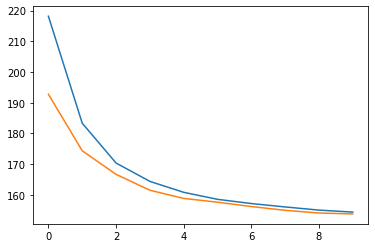

In [13]:
plt.plot(his.history['loss'], label='loss')
plt.plot(his.history['val_loss'], label = 'val_loss')

## The latent space

In this part the latent space is visualized (since the latent space is two dimensional this is a rather easy task).
The test dataset is predicted by the encoder and it can be observed that different digits are located in almost separated areas (clusters). 

In [14]:
test_outs = encoder.predict(test_x)
test_outs = test_outs[2]
x = np.array(test_outs)[:,0]
y = np.array(test_outs)[:,1]

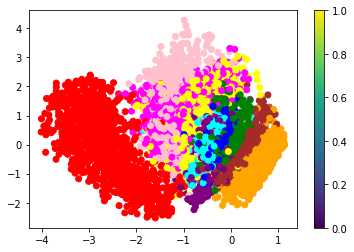

In [15]:
colors = {1:'red', 2 :'green', 3:'blue', 4:'yellow', 5: 'purple', 6: 'brown', 7:'pink', 8:'cyan', 9:'magenta', 0:'orange'}
data = {"x": x, "y":y, "num": test_y}
df = pd.DataFrame(data)
fig, ax = plt.subplots()
plt.scatter(df["x"], df["y"], c=df["num"].map(colors))
plt.colorbar()
plt.show()

## Sample Generation
First we can take a look at some samples from the test dataset. 

In [95]:
def generate_image(count):
    start = 5000
    end = start+count
    new_images = vae.predict(np.array(test_x[start:end]))
    new_images = new_images.reshape(count, 28, 28,1)
    scaled_up = new_images*255
    for i in range(count):
        plt.subplot(2, int(count/2),i+1)
        plt.title(test_y[start+i])
        plt.imshow(scaled_up[i], cmap='gray')
    plt.show()

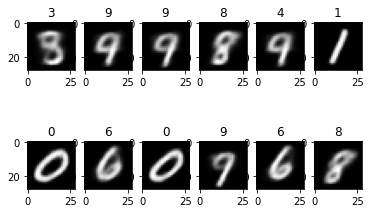

In [96]:
generate_image(12)

Next we can take a look at some random samples

In [99]:
def generate_random(count):
    ax = []
    for i in range(count):
        t = []
        for j in range(2):
            t.append(8*random.uniform(0, 1)-4)
        ax.append(np.array(t))
   
    for i in ax:
        i = i[:, np.newaxis]
    ax =  np.array(ax)   

    new_images = decoder.predict(ax)
    new_images = new_images.reshape(count, 28, 28,1)
    scaled_up = new_images*255
    for i in range(count):
        plt.subplot(1, count,i+1)
        plt.imshow(scaled_up[i], cmap='gray')
    plt.show()

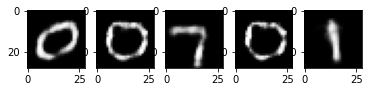

In [100]:
generate_random(5)

## Interpolating in the latent space
In this part we consider two data points in the test dataset and decode some points in between.

In [101]:
def interpolate(source,target,sli):
    inputs = [test_x[source],test_x[target]]
    x = encoder.predict(np.array(inputs))
    first = np.linspace(x[2][0][0], x[2][1][0],sli)
    sec = np.linspace(x[2][0][1], x[2][1][1],sli)
    latent = []
    for i in range(sli):
        latent.append([first[i],sec[i]])
    new_images = decoder.predict(np.array(latent))
    new_images = new_images.reshape(sli, 28, 28,1)
    scaled_up = new_images*255
    for i in range(sli):
        plt.subplot(1, sli,i+1)
        plt.imshow(scaled_up[i], cmap='gray')
    plt.show()
        

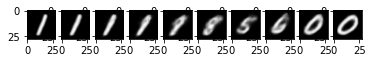

In [102]:
interpolate(5005,5006,10)

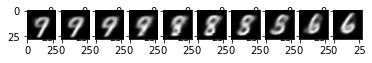

In [103]:
interpolate(5009,5010,10)